In [4]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from PIL import Image


In [5]:
 # Choose between 'MRI' or 'ct'
data_dir = r'C:\Users\jmana\Desktop\model\ct'  # or 'ct'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# Basic transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
from torchvision.models import resnet18

def get_resnet_model(num_classes):
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_resnet_model(len(class_names)).to(device)


c:\Users\jmana\Desktop\model\tumor_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jmana\Desktop\model\tumor_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, test_losses, train_accs, test_accs = [], [], [], []


In [8]:
for epoch in range(num_epochs):
    model.train()
    correct, total, epoch_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(correct / total)

    # Evaluation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_losses.append(val_loss / len(test_loader))
    test_accs.append(correct / total)
    
    print(f"Epoch {epoch+1}/{num_epochs} → Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_accs[-1]:.4f}")


Epoch 1/10 → Train Acc: 0.7295, Test Acc: 0.6575
Epoch 2/10 → Train Acc: 0.8272, Test Acc: 0.7246
Epoch 3/10 → Train Acc: 0.8701, Test Acc: 0.8207
Epoch 4/10 → Train Acc: 0.8974, Test Acc: 0.7895
Epoch 5/10 → Train Acc: 0.9261, Test Acc: 0.9054
Epoch 6/10 → Train Acc: 0.9396, Test Acc: 0.8955
Epoch 7/10 → Train Acc: 0.9524, Test Acc: 0.7788
Epoch 8/10 → Train Acc: 0.9587, Test Acc: 0.9245
Epoch 9/10 → Train Acc: 0.9669, Test Acc: 0.9558
Epoch 10/10 → Train Acc: 0.9771, Test Acc: 0.9565


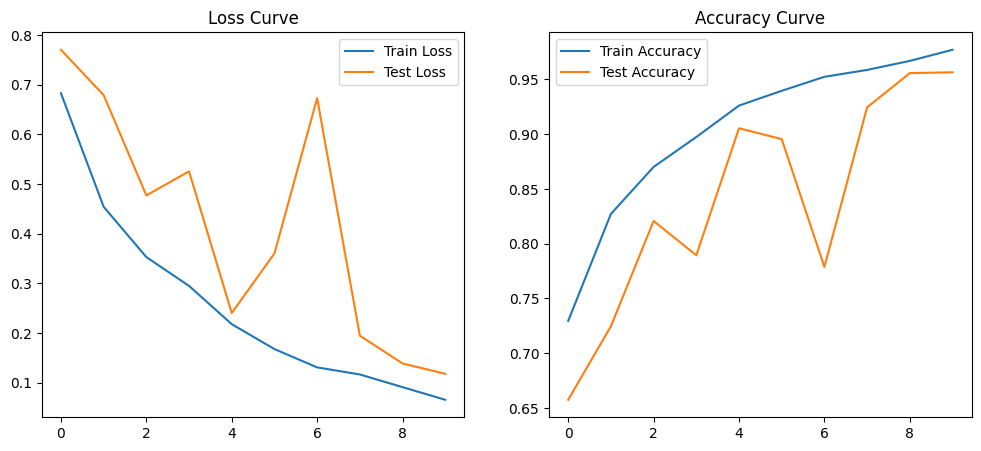

In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


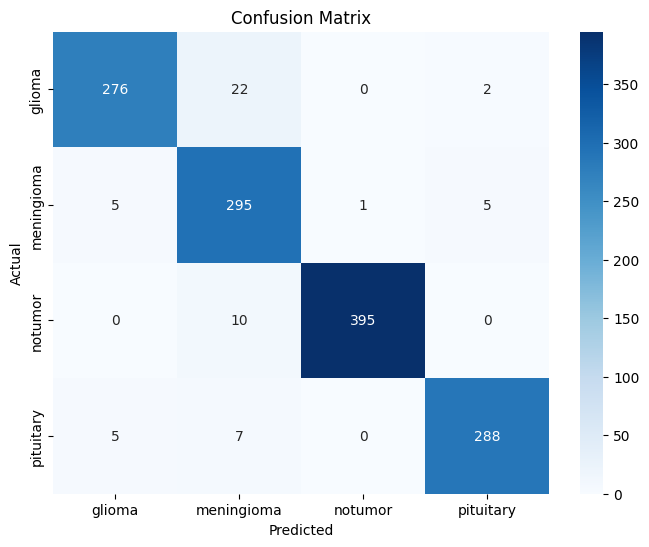

Classification Report:

              precision    recall  f1-score   support

      glioma       0.97      0.92      0.94       300
  meningioma       0.88      0.96      0.92       306
     notumor       1.00      0.98      0.99       405
   pituitary       0.98      0.96      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



In [10]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))



In [11]:
def predict_image(image_path, model, transform, class_names):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()
        confidence = prob[0][pred].item()

    print(f"Predicted Tumor Type: {class_names[pred]}")
    print(f"Confidence: {confidence:.2f}")




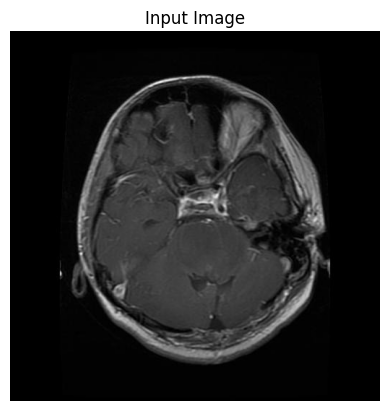

Predicted Tumor Type: glioma
Confidence: 1.00


In [12]:
predict_image(r"C:\Users\jmana\Desktop\model\ct\Testing\glioma\Te-gl_0010.jpg", model, transform, class_names)


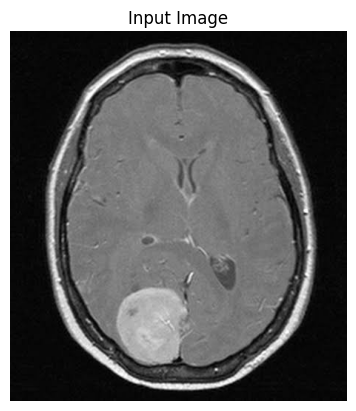

Predicted Tumor Type: meningioma
Confidence: 0.99


In [13]:
predict_image(r"C:\Users\jmana\Desktop\model\ct\Testing\meningioma\Te-me_0010.jpg", model, transform, class_names)


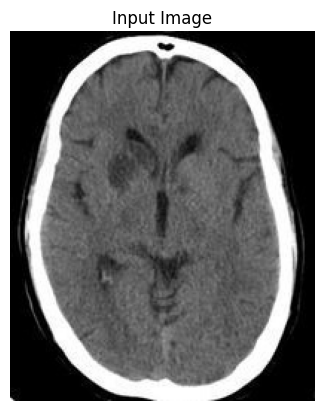

Predicted Tumor Type: notumor
Confidence: 1.00


In [14]:
predict_image(r"C:\Users\jmana\Desktop\model\ct\Testing\notumor\Te-no_0010.jpg", model, transform, class_names)


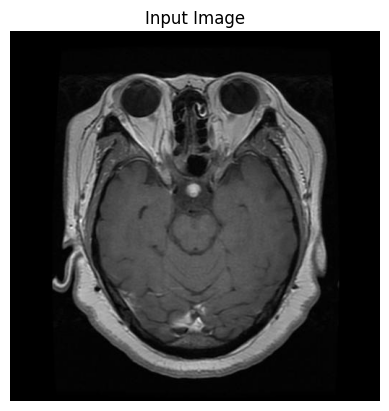

Predicted Tumor Type: pituitary
Confidence: 1.00


In [15]:
predict_image(r"C:\Users\jmana\Desktop\model\ct\Testing\pituitary\Te-pi_0010.jpg", model, transform, class_names)
